# Simulation of infection spreads in a network

This demo will run a simulation in how an infection can spread in a small network.

Initial idea: model the people as a graph. This limits the direct neighbors to 8, but we will change this assumption later on. Also, populate the matrix randomly.

Couple of assumptions:
1. Once a node is infected, it is cured after *d* days, unless it dies.
2. Once a node is cured after being infected, it has immunity to infection till *n* days.
3. Once infected, a node has 0.03 probability of death. To simplify things, I will assume death happens in 14 days as well.
4. Nodes don't move.
5. Every turn of the simulation marks one day.

In [1]:
import numpy as np
import matplotlib.pyplot as plot
from typing import Callable, Iterator, Union, Optional, List
import networkx as nx

%matplotlib inline
import time

I use `ipycytoscape` as my visualization library, which will allow me to interact with graphs directly

In [2]:
import ipycytoscape
import ipywidgets as widgets

I keep a `Status` enum to denote node health

In [3]:
class Status:
    HEALTHY = 'HEALTHY'   # will be in blue
    IMMUNE = 'IMMUNE'     # will be in green
    INFECTED = 'INFECTED' # will be in red
    DEAD = 'DEAD'         # will be greyed out

css_style = [
                        {
                            'selector': 'node.HEALTHY',
                            'css': {
                                'background-color': 'blue'
                            }
                        },
                        {
                            'selector': 'node.INFECTED',
                            'css': {
                                'background-color': 'red'
                            }
                        },
                        {
                            'selector': 'node.IMMUNE',
                            'css': {
                                'background-color': 'green'
                            }
                        }]

For my `Node` class, I keep a simple structure. I keep track of the current "health" of the node, and keep two counters to keep track of infection and immunity time. I also model whethere the node will die from getting an infection.

In [4]:
class MyNode(ipycytoscape.Node):
    MAX_IMMUNITY_TIME = 4
    MAX_INFECTED_TIME = 2
    PROB_DEATH = 0
    def __init__(self,
                 nodeNum: int,
                 maxImmunityTime: int, 
                 maxInfectionTime: int,
                 probDeath: int,
                 status: Status = Status.HEALTHY):
        super().__init__()
        self.data['id'] = nodeNum
        self.maxImmunityTime = maxImmunityTime
        self.maxInfectionTime = maxInfectionTime
        self.probDeath = probDeath
        self.classes = status
        self.infectionTime = 0
        self.immunityTime = 0
        self.willDie = 0
        
    def __str__(self):
        temp = super().__str__()
        return f"super: {temp}, infectionTime: {self.infectionTime}, immunityTime: {self.immunityTime}, willDie: {self.willDie}"
    
    def processCycle(self, time: int, infect: bool) -> bool:
        """
        infect is kind of like a signal that the node receives at time t.
        It denotes whether the node will be infected in this cycle or not.
        If node is already infected or immune, this won't have any effect.
        
        This function returns True if the node was infected and died
        and false if it is still alive
        """
        if self.classes == Status.DEAD:
            return True
        if infect:
            if self.classes == Status.HEALTHY:
                self.infect(time)
            return False

        if self.classes == Status.IMMUNE:
            if time - self.immunityTime > self.maxImmunityTime:
                self.disinfect()
            return False

        if self.classes == Status.INFECTED:
                if time - self.infectionTime > self.maxInfectionTime:
                    if self.willDie:
                        self.classes = Status.DEAD
                        return True
                    self.immune(time)
        return False
    
    def immune(self, time: int):
        self.classes = Status.IMMUNE
        self.immunityTime = time
        self.infectionTime = 0

    
    def disinfect(self):
        self.classes = Status.HEALTHY
        self.infectionTime = 0
        self.immunityTime = 0

        
    def infect(self, infected_time: int):
        self.infectionTime = infected_time
        self.classes = Status.INFECTED
        self.immunityTime = 0
        self.willDie = np.random.choice([1,0], 1, p=[self.probDeath, 1-self.probDeath])[0]


Finally, I create my network. Healthy nodes are indicated in blue, while infected are in red, and immune are in green.

For my network, I use the **Barbasi-Albert** model. I tried several others as well (Erdős–Rényi, Watts–Strogatz, but settled on this one in the end due to its closeness to real world networks).

In this model, the probability p(i) that the new node is connected to node i is:

    p(i) = k(i)/(∑ k(j))

where k(i) is the degree of node i and the sum is made over all pre-existing nodes j (i.e. the denominator results in twice the current number of edges in the network).

Essentially, this graph follows the small world property and has the power law that is present for real world networks. (It is similar to the example of chinese restaurant.)

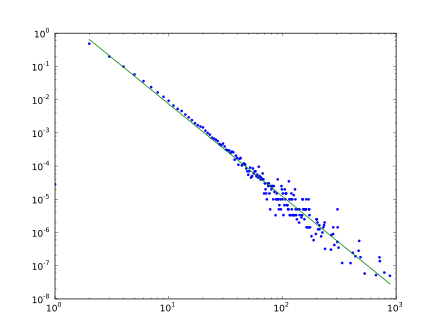

The main part of the code is the `simulateOneCycle`. This is a method which can easily be parallelized (though I haven't done it here). It basically iterates over the infected nodes, and tries to infect the neighboring nodes.

In [5]:
class Network:
    def __init__(self, numNodes: int = 200, 
                 probEdges: int = 2, 
                 infectionTime = MyNode.MAX_INFECTED_TIME, 
                 immunityTime = MyNode.MAX_IMMUNITY_TIME,
                 probInfection = 0.2):
        self.probInfection = probInfection
        self.time = 0
        self.numNodes = numNodes
        self.infectedNodes = set()
            
        
        mapping = [MyNode(nodeNum = i, maxImmunityTime = immunityTime,
                                   maxInfectionTime = infectionTime, probDeath=0) for i in range(numNodes)]
        sample_graph = nx.barabasi_albert_graph(numNodes, probEdges)
        self.graph = nx.Graph()
        for i in range(numNodes):
            self.graph.add_node(mapping[i])
        for edge in sample_graph.edges:
            left = edge[0]
            right = edge[1]
            self.graph.add_edge(mapping[left], mapping[right])
        
            
    def initializeInfected(self, infected: float = 0.05):
        prob = np.random.choice([0,1], self.numNodes, p=[infected, 1-infected])
        self.infectedNodes = set()
        i = 0
        for node in self.graph.nodes:
            if prob[i] == 0:
                node.infect(0)
                self.infectedNodes.add(node)
            else:
                node.disinfect()
            i += 1
        self.time = 0
            
            
    def neighbor(self, i: int) -> List[MyNode]:
        return self.graph.neighbors(i)
    
    def simulateOneCycle(self):
        self.time = self.time+1
        
        # first gather the list of nodes which will be infected this cycle
        to_be_infected_nodes = set()
        for i in self.infectedNodes:
            numNeighbor = 0
            for x in self.neighbor(i):
                numNeighbor += 1
            probInfection = np.random.choice([1,0], numNeighbor, 
                                             p=[self.probInfection, 1 - self.probInfection])
            
            j = 0
            for neighbor in self.neighbor(i):
                if probInfection[j]:
                    to_be_infected_nodes.add(neighbor) # add probability here
                j += 1

                
        self.infectedNodes = set()
        # Now, run the simulation for all nodes, keeping track of newly infected nodes
        for node in self.graph.nodes:
            if node in to_be_infected_nodes:
                node.processCycle(self.time, True)
            else:
                node.processCycle(self.time, False)
            if node.classes == Status.INFECTED:
                self.infectedNodes.add(node)
        if len(self.infectedNodes) == 0:
            return True
        return False
    
    def simulate(self, infected: float = None, delay: int = 500, days: int = 50):
        if infected is not None: 
            x.initializeInfected(infected = infected)
        for i in range(days):
            time.sleep(delay/1000)
            if self.simulateOneCycle():
                return i
                break
        return days
        
                

In [ ]:
x = Network(100, probEdges=2, infectionTime=4, immunityTime=6, probInfection=0.1)
x.initializeInfected(infected = 0.2)


In [7]:
widget = ipycytoscape.CytoscapeWidget()
widget.set_layout(nodeSpacing=10, animation=False)
widget.graph.add_graph_from_networkx(x.graph)
widget.set_style(css_style)

In [8]:
display(widget)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 10, 'animation': False}, cytoscape_style=[{'s…

In [9]:
i = x.simulate(days=150)

In [10]:
i

20

Now, I want to model some more things:
1. The probability of someone dying (or leaving this network)
2. ~The probability of birth (or someone new arriving in this network)~

For simplicity of model, I will assume that each time a new node is added to the network, it is healthy.

In [6]:
class Network2(Network):
    
    def __init__(self, numNodes: int = 200, 
                 probEdges: float = 0.02, 
                 infectionTime = MyNode.MAX_INFECTED_TIME, 
                 immunityTime = MyNode.MAX_IMMUNITY_TIME,
                 probDeath = 0.2,
                 probBirth = 0.2,
                 probInfection = 0.2):
        self.probInfection = probInfection
        self.time = 0
        self.numNodes = numNodes
        self.infectedNodes = set()
            
        
        mapping = [MyNode(nodeNum = i, maxImmunityTime = immunityTime,
                                   maxInfectionTime = infectionTime, probDeath=probDeath) for i in range(numNodes)]
        sample_graph = nx.barabasi_albert_graph(numNodes, probEdges)
        self.graph = nx.Graph()
        for i in range(numNodes):
            self.graph.add_node(mapping[i])
        for edge in sample_graph.edges:
            left = edge[0]
            right = edge[1]
            self.graph.add_edge(mapping[left], mapping[right])
        
    def initializeInfected(self, infected: float = 0.05):
        prob = np.random.choice([0,1], self.numNodes, p=[infected, 1-infected])
        self.infectedNodes = set()
        i = 0
        for node in self.graph.nodes:
            if prob[i] == 0:
                node.infect(0)
                self.infectedNodes.add(node)
            else:
                node.disinfect()
            i += 1
        self.time = 0
            
            
    def neighbor(self, i: int) -> List[MyNode]:
        return self.graph.neighbors(i)
    
    def simulateOneCycle(self):
        self.time = self.time+1
        
        # first gather the list of nodes which will be infected this cycle
        to_be_infected_nodes = set()
        for i in self.infectedNodes:
            numNeighbor = 0
            for x in self.neighbor(i):
                numNeighbor += 1
            probInfection = np.random.choice([1,0], numNeighbor, 
                                             p=[self.probInfection, 1 - self.probInfection])
            
            j = 0
            for neighbor in self.neighbor(i):
                if probInfection[j]:
                    to_be_infected_nodes.add(neighbor) # add probability here
                j += 1

                
        self.infectedNodes = set()
        # Now, run the simulation for all nodes, keeping track of newly infected nodes and removing and adding nodes
        deadNodes = []
        for node in self.graph.nodes:
            isDead = node.processCycle(self.time, node in to_be_infected_nodes)
            if isDead:
                deadNodes.append(node)
            if node.classes is Status.INFECTED and not isDead:
                self.infectedNodes.add(node)
        
        # remove the dead nodes now
        for node in deadNodes:
#             print("Removing node", node.data["id"])
            self.graph.remove_node(node)
    
        # add the new nodes
        if len(self.infectedNodes) == 0:
            return True
        return False
    
    def simulate(self, infected: float = None, delay: int = 500, days: int = 50):
        if infected is not None: 
            x.initializeInfected(infected = infected)
        days_taken = 0
        for i in range(days):
            time.sleep(20/1000)
            if self.simulateOneCycle():
                return i, self.numNodes - len(x.graph.nodes.items()), True
                break
        days_taken = i
        return days, self.numNodes - len(x.graph.nodes.items()), False
            

In [49]:
result = []
for i in range(20):
    x = Network2(200, probEdges=2, infectionTime=4, immunityTime=12, probInfection=0.6, probDeath=0.1, probBirth=0)
    x.initializeInfected(infected = 0.1)
    result.append(x.simulate(days=200))
m[0.6] = result

In [39]:
probs = [0.05, 0.1, 0.2, 0.4, 0.6]
m = {}
for k in probs:
    result = []
    for i in range(20):
        print("simulation " + str(i))
        x = Network2(200, probEdges=2, infectionTime=4, immunityTime=12, probInfection=k, probDeath=0.1, probBirth=0)
        x.initializeInfected(infected = 0.1)
        result.append(x.simulate(days=100))
    m[k] = result

simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simu

In [50]:
m

{0.05: [(16, 10, True),
  (25, 6, True),
  (18, 7, True),
  (23, 8, True),
  (18, 12, True),
  (20, 5, True),
  (19, 11, True),
  (36, 14, True),
  (29, 9, True),
  (26, 9, True),
  (22, 5, True),
  (22, 5, True),
  (17, 14, True),
  (19, 10, True),
  (20, 5, True),
  (23, 10, True),
  (24, 11, True),
  (38, 7, True),
  (26, 9, True),
  (23, 7, True)],
 0.1: [(34, 16, True),
  (100, 39, False),
  (25, 13, True),
  (21, 19, True),
  (22, 11, True),
  (20, 12, True),
  (17, 22, True),
  (18, 18, True),
  (22, 16, True),
  (20, 11, True),
  (19, 21, True),
  (23, 12, True),
  (92, 34, True),
  (26, 10, True),
  (23, 20, True),
  (19, 21, True),
  (17, 22, True),
  (23, 11, True),
  (24, 16, True),
  (19, 11, True)],
 0.2: [(15, 18, True),
  (16, 25, True),
  (15, 19, True),
  (15, 23, True),
  (17, 15, True),
  (22, 16, True),
  (16, 16, True),
  (18, 21, True),
  (17, 15, True),
  (17, 16, True),
  (20, 19, True),
  (17, 15, True),
  (17, 18, True),
  (17, 15, True),
  (17, 26, True),
  

In [53]:
x = m[0.6]

In [55]:
del m[0.6]

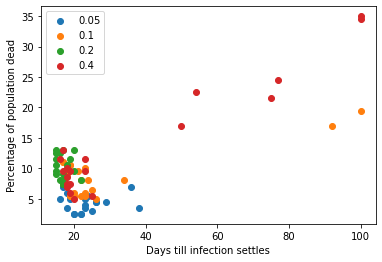

In [64]:
for k in m:
    result = m[k]
    days, y, lasd = zip(*result)
    dead = [d/2 for d in y]
    plot.scatter(days, dead, label=str(k))
    plot.legend()
    plot.xlabel("Days till infection settles")
    plot.ylabel("Percentage of population dead")

In [8]:
prob_dead = [0.01, 0.05, 0.1, 0.15, 0.2]
m_dead = {}
for k in prob_dead:
    result = []
    for i in range(20):
        print("simulation " + str(i))
        x = Network2(200, probEdges=2, infectionTime=4, immunityTime=12, probInfection=0.2, probDeath=k, probBirth=0)
        x.initializeInfected(infected = 0.1)
        result.append(x.simulate(days=100))
    m_dead[k] = result

simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simu

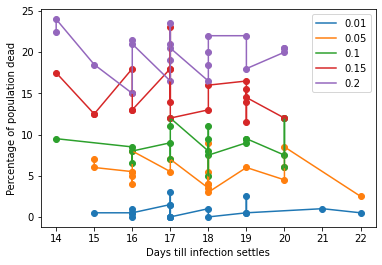

In [24]:
for k in m_dead:
    result = m_dead[k]
    days, y, lasd = zip(*result)
    days = sorted(days)
    dead = [d/2 for d in y]
    plot.plot(days, dead, label=str(k))
    plot.scatter(days, dead)
    plot.legend()
    plot.xlabel("Days till infection settles")
    plot.ylabel("Percentage of population dead")

In [25]:
prob_edges = [1, 2, 3, 4, 5]
m_edges = {}
for k in prob_edges:
    result = []
    for i in range(20):
        print("simulation " + str(i))
        x = Network2(400, probEdges=k, infectionTime=4, immunityTime=12, probInfection=0.2, probDeath=0.1, probBirth=0)
        x.initializeInfected(infected = 0.1)
        result.append(x.simulate(days=100))
    m_edges[k] = result

simulation 0
simulation 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 2
simulation 3
simulation 4


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 6
simulation 7
simulation 8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 10
simulation 11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 13
simulation 14


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 16
simulation 17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 18
simulation 19


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 0
simulation 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 3
simulation 4


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 6


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 8
simulation 9


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 10
simulation 11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 13
simulation 14


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 16


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 18
simulation 19


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 1
simulation 2


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 3
simulation 4


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 6
simulation 7


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 8
simulation 9


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 11
simulation 12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 14


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 16
simulation 17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 19
simulation 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 2
simulation 3


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 4
simulation 5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 7
simulation 8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 9


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 10
simulation 11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 13


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 14
simulation 15


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 19
simulation 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 2


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 3


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 4


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 6
simulation 7


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 8


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 9


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 10


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 11


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 12


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 13


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 14
simulation 15


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 16
simulation 17


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 18


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



simulation 19


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



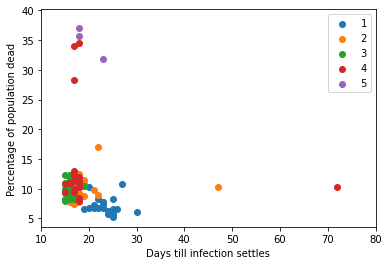

In [44]:
for k in m_edges:
    result = m_edges[k]
    days, y, lasd = zip(*result)
    days = sorted(days)
    dead = [d/4 for d in y]
    plot.scatter(days, dead, label=str(k))
#     plot.scatter(days, dead)
    plot.legend()
    plot.xlim([10,80])
    plot.xlabel("Days till infection settles")
    plot.ylabel("Percentage of population dead")

In [41]:
m_edges[5]

[(100, 148, False),
 (100, 143, False),
 (100, 127, False),
 (100, 132, False),
 (100, 146, False),
 (100, 140, False),
 (23, 40, True),
 (100, 133, False),
 (100, 142, False),
 (100, 136, False),
 (100, 112, False),
 (100, 154, False),
 (100, 142, False),
 (100, 154, False),
 (18, 41, True),
 (100, 146, False),
 (18, 55, True),
 (100, 119, False),
 (100, 132, False),
 (100, 147, False)]

# TODOs:

I am still working on a few things:
1. Integrating the birth/arrival of new nodes in the network
2. Parallelizing the code, so it runs fast on GPUs. 
3. More importantly, the nature of link between two nodes. For that I have plans to assign weights to edges, and instead of a fixed probability of infection spread, I will be using that weight as the probability of infection.
4. Lastly, I want to model changing the weights as well, to reflect how people grow closer/grow distant over time. I am still looking for a model which does this for a real world network, instead of just changing the weights randomly

### Further work
1. Effects of lockdown, both on partial segment of graph and full segment
2. Effects of vaccine, which will decrease the probability of infection, and make immunity last longer.
3. Modeling herd immunity. (The percentage of nodes that need to become immune so that virus will stop spreading)